In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [43]:
def pct_dif(df1, df2):
    """ generate a percentage based difference table
        df1 and df2 have same index and columns
        pct_dif set to 0 where df2-df1 equals to 0 
        pct_dif rows are removed if cell values are infs (df2-df1>0 but df1 is 0)    
    """
    df_diff = df2.subtract(df1, axis =1)
    df_pct_diff = df_diff.div(df1, axis=1) * 100.0
    df_pct_diff.update(df_diff[df_diff==0])
    df_pct_diff = df_pct_diff.replace([np.inf, -np.inf],np.nan).dropna(axis=0)

    return df_pct_diff

In [44]:
def sub_error_plot(df, ax=None, tle_text=""):
    """
    df generated from pct_diff.describe()
    plot shows mean values   
    """
    if ax is None:
        ax = plt.gca()
    ax.vlines(0, 0, len(df)) #draw the y axis on 0
    ax.errorbar(df['mean'], range(len(df.index)), 
                xerr= [df['mean'] - df['min'], df['max'] - df['mean']], 
                fmt='ok', ecolor='gray', lw=1, capsize=8)
    ax.errorbar(df['mean'], range(len(df.index)), xerr=df['std'], fmt='ok', lw=4)

    for (x,y,l) in zip(df['mean'],  range(len(df.index)), round(df['mean'],3)):
        ax.text(50, y + 0.1, l, size=20)

    ax.set_title( tle_text + ' PCT ERRORS')
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index)

    return ax

In [45]:
def compare_plots(lst_dfs):
    """
    subplots with dimension 1 x X (X is the number of df being compared)
    df should have name
    """
    sns.set(font_scale=2)   
    fig, axs = plt.subplots(1, len(lst_dfs), sharex=True, sharey=True, 
                            figsize=(30, max(5, len(lst_dfs[0]))), 
                            gridspec_kw={'hspace': 0, 'wspace': 0.02})
    c=0
    for df in lst_dfs:
        sub_error_plot(df, axs[c], " ".join(df.name.split("_")))
        c += 1

    return fig

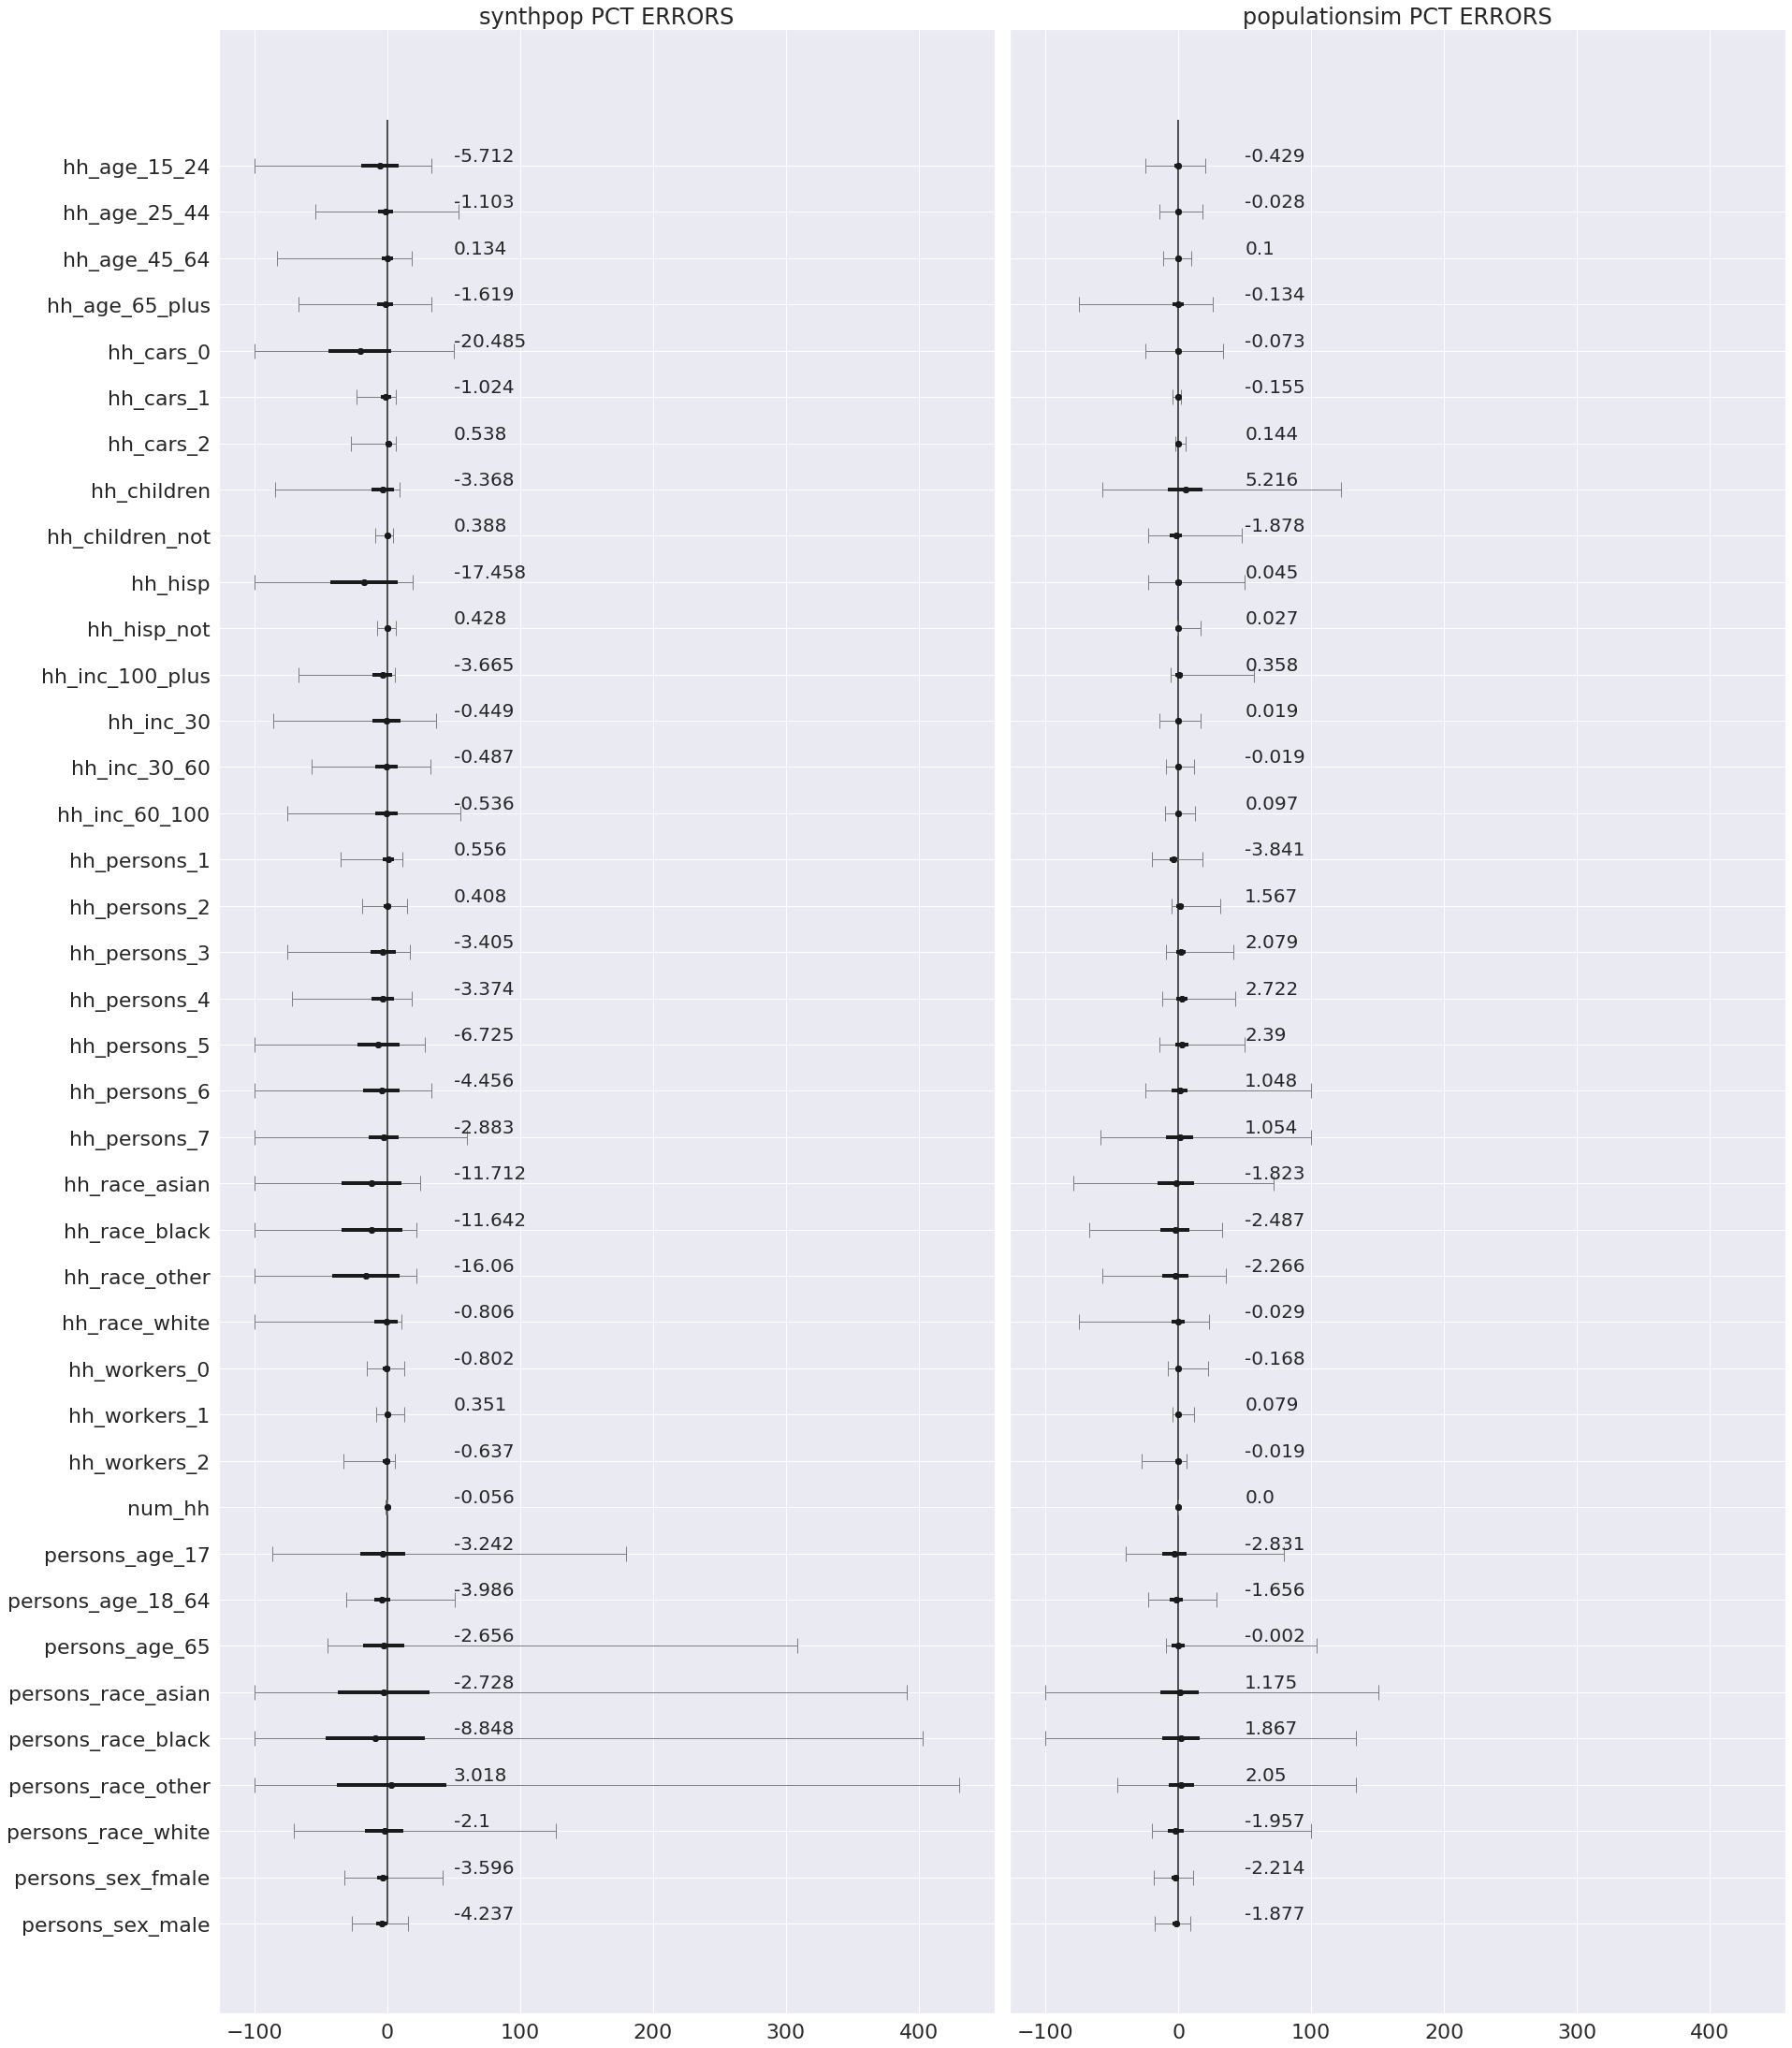

In [46]:
dt_sum = {'synpop': 'synthpop/oakland_BLKGRP_summary.csv', 'result':'output/summary_BLKGRP.csv'}
names = {'synpop': 'synthpop', 'result':'populationsim'}
lst_dfs = []
lst_diffs = []

for k in dt_sum.keys():
    dfr = pd.read_csv(dt_sum[k], index_col = 'id')
    flds = [x.replace('_control', '') for x in dfr.columns.values if x.find('_control') >=0 ]
    controls = [ x + '_control' for x in flds]
    results = [ x + "_" + k for x in flds]
    df1=dfr[controls]
    df1.columns=flds
    df2=dfr[results]
    df2.columns=flds
    df_cpt_dif = pct_dif(df1, df2)
    df_cpt_dif.name = k
    lst_diffs.append(df_cpt_dif)

    dfp = df_cpt_dif.describe().T.sort_index(axis = 0, ascending = False)
    dfp.name = names[k]
    lst_dfs.append(dfp)


fig= compare_plots(lst_dfs)
fig.savefig('validation/semcog_python/synpop_popsim_error_plot.png', bbox_inches = "tight")


## Histograms by attributes

In [81]:
import base64
from io import BytesIO
sns.set()

plot_folder = 'validation/semcog_python/'

for df in lst_diffs:
    html = """<!DOCTYPE html>  <html>
            <head> <title>%s</title> </head> <body>
            """ % "_".join([names[df.name],'_histograms'])
    sns.set(font_scale=2) 
    lay = (int(len(df.columns)/3), 3)
    ax = df.hist(bins=100, xlabelsize =15, ylabelsize =15, layout=lay, figsize =(21,70))
    fig = ax[0][0].get_figure()
    fig.tight_layout()

    tmpfile = BytesIO()
    fig.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = html + '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

    fig.clf()

    html = html + """</body> </html>"""
    with open(plot_folder + "_".join([names[df.name], '_histograms.html']),'w') as f:
        f.write(html)

<Figure size 1512x5040 with 0 Axes>

<Figure size 1512x5040 with 0 Axes>